In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
# Example Feature Extraction from XML Files
# We count the number of specific system calls made by the programs, and use
# these as our features.

# This code requires that the unzipped training set is in a folder called "train". 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util

TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = set([])

def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

def create_data_matrix(start_index, end_index, direc):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break
        
        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        add_to_set(tree)
        X_row = call_feats(tree)
        swizzor = check_swizzor(tree)
        nProcesses = n_Processes(tree)
        this_row = np.hstack((X_row, swizzor, nProcesses))
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

def call_feats(tree):
    calls = ['all_section', 'bind_socket', 'check_for_debugger',
       'com_create_instance', 'com_get_class_object', 'connect',
       'connect_socket', 'copy_file', 'create_directory', 'create_file',
       'create_key', 'create_mutex', 'create_open_file', 'create_process',
       'create_socket', 'create_thread', 'create_window', 'delete_file',
       'delete_key', 'delete_value', 'destroy_window', 'dump_line',
       'enum_keys', 'enum_processes', 'enum_values', 'enum_window',
       'find_file', 'find_window', 'get_computer_name',
       'get_file_attributes', 'get_host_by_name', 'get_system_directory',
       'get_system_time', 'get_username', 'get_windows_directory',
       'impersonate_user', 'kill_process', 'load_dll', 'load_image',
       'open_file', 'open_key', 'open_mutex', 'open_process',
       'open_scmanager', 'open_service', 'open_url', 'process',
       'processes', 'query_value', 'read_section', 'read_value',
       'recv_socket', 'remove_directory', 'send_socket',
       'set_file_attributes', 'set_file_time', 'set_value',
       'set_windows_hook', 'show_window', 'sleep', 'thread',
       'trimmed_bytes', 'vm_protect', 'write_value']

    call_counter = {}
    for el in tree.iter():
        call = el.tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1

    call_feat_array = np.zeros(len(calls))
    for i in range(len(calls)):
        call = calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]

    return call_feat_array

def check_swizzor(tree) :
    root = tree.getroot()
    process = []
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
        
    for i in range(len(process) - 1) :
        first = process[i]
        second = process[i+1]
        
        if "iexplore.exe" in first and ("services.exe" in second or "svchost.exe" in second):
            return 1
            break
    
    return 0

def n_Processes(tree) :
    root = tree.getroot()
    process = []
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
        
    return len(process)

In [13]:
%%time
X_train, y_train, train_ids = create_data_matrix(0, 3086, TRAIN_DIR)
print X_train.shape
print y_train.shape

(3086, 66)
(3086,)
CPU times: user 36.3 s, sys: 1.97 s, total: 38.3 s
Wall time: 42.2 s


In [24]:
%%time
X_test, y_test, test_ids = create_data_matrix(0, 3724, TEST_DIR)
print X_test.shape
print y_test.shape

(3724, 64)
(3724,)
CPU times: user 2min 45s, sys: 7.55 s, total: 2min 53s
Wall time: 3min 1s


In [31]:
np.save('save/X_train',X_train)
np.save('save/X_test',X_test)
np.save('save/y_train',y_train)
np.save('save/y_test',y_test)
np.save('save/train_ids',train_ids)
np.save('save/test_ids',test_ids)

In [33]:
X_train = np.load('save/X_train.npy')
X_test = np.load('save/X_test.npy')
y_train = np.load('save/y_train.npy')
y_test = np.load('save/y_test.npy')
train_ids = np.load('save/train_ids.npy')
test_ids = np.load('save/test_ids.npy')

In [34]:
def log0(matrix):
    return np.log(matrix + 1)

In [23]:
def normalize1(array) :
    rowsum = np.sum(array)
    newrow = array / float(rowsum)
    return np.append(newrow, rowsum)

In [14]:
import sys
import random

def see_mat(matrix, index='c', i=0) :
    if index not in ['c', 'r'] :
        print "You must choose a column or row"
        
    if index == 'c' :
        if i >= matrix.shape[1] :
            print "Column does not exist"
        else :
            return matrix[:,i]
    elif index == 'r' :
        if i >= matrix.shape[0] :
            print "Row does not exist"
        else :
            return matrix[i,:]
        
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def accuracy_score(arr1, arr2) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        print 'Accuracy: ' + str(len(np.where(arr1 == arr2)[0])/float(arr1.shape[0]))
    
    plt.scatter(rand_jitter(arr1), rand_jitter(arr2), alpha=0.1);
    plt.xlabel('Predictions');
    plt.ylabel('True classification');

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


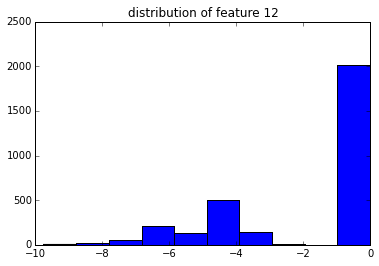

In [194]:
# Visualize different effects ...
X_train_normalize1 = mat_log(np.apply_along_axis(normalize1, 1, X_train),0)

random_num = random.randint(0, 63)
plt.hist(see_mat(X_train_normalize1, 'c', random_num));
plt.title('distribution of feature ' + str(random_num));

Baseline (predicting all as 'none')
Accuracy: 0.52138690862
None


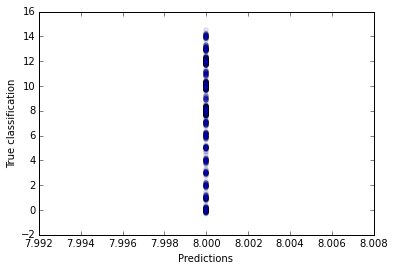

In [191]:
baseline = [8] * y_train.shape[0]
print "Baseline (predicting all as 'none')"
print accuracy_score(baseline, y_train)

In [15]:
import sklearn.cross_validation as cv
X_none_train, X_none_test, y_none_train, y_none_test = cv.train_test_split(X_train, y_train, test_size = 0.33, random_state=32)

def addIndicator(data) :
    nFeatures = data.shape[1]
    newdata = data.copy()
    for i in range(nFeatures) :
        newcol = (data[:,i] == 0).astype(int)
        newdata = np.append(newdata, np.matrix(newcol).T, axis=1)
    return newdata

X_ind = addIndicator(X_train)
X_ind_train, X_ind_test, y_ind_train, y_ind_test = cv.train_test_split(X_ind, y_train, test_size = 0.33, random_state=32)

Logistic regression (no hyperparameter fitting)
No indicators used
Accuracy: 0.676153091266
None


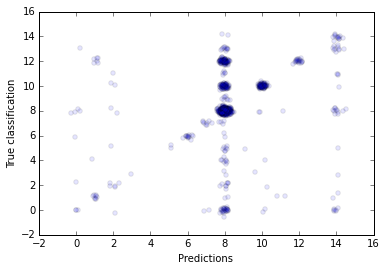

In [20]:
from sklearn import linear_model
LR = linear_model.LogisticRegression()
LR.fit(X_none_train, y_none_train)
LR_pred = LR.predict(X_none_test)

print "Logistic regression (no hyperparameter fitting)"
print "No indicators used"
print accuracy_score(y_none_pred, y_none_test)

Logistic regression (no hyperparameter fitting)
Indicators used
Accuracy: 0.696761530913
None


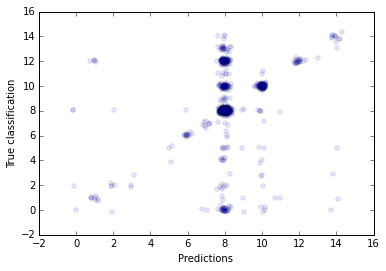

In [59]:
LR = linear_model.LogisticRegression()
LR.fit(X_ind_train, y_ind_train)
y_ind_pred = LR.predict(X_ind_test)

print "Logistic regression (no hyperparameter fitting)"
print "Indicators used"
print accuracy_score(y_ind_pred, y_ind_test)

KNN (no hyperparameter fitting)
No indicators
Accuracy: 0.845927379784
None


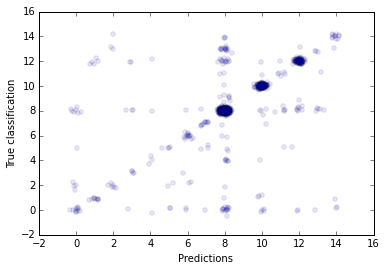

In [18]:
from sklearn import neighbors
n_neighbors = 15

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_none_train, y_none_train)
y_none_pred = clf.predict(X_none_test)

print "KNN (no hyperparameter fitting)"
print "No indicators"
print accuracy_score(y_none_pred, y_none_test)

KNN (no hyperparameter fitting)
Accuracy: 0.846908734053
None


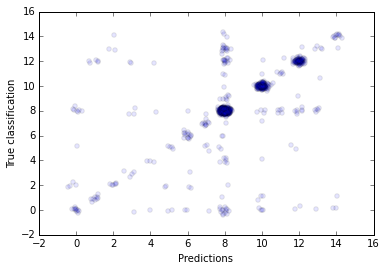

In [19]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_ind_train, y_ind_train)
y_ind_pred = clf.predict(X_ind_test)

print "KNN (no hyperparameter fitting)"
print accuracy_score(y_ind_pred, y_ind_test)

In [63]:
class_priors = 0.0001 * np.array([369, 162, 120, 103, 133, 126, 172, 
                                  133, 5214, 68, 1756, 104, 1218, 191, 130])

In [64]:
from collections import defaultdict
import scipy.stats as dist
import math

def separateByClass(xdata, ydata) :
    separated = defaultdict()
    uniqueClasses = np.unique(ydata)
    for i in uniqueClasses :
        separated[i] = xdata[ydata == i,:]
    return separated

def summarize(matrix) :
    return [(np.mean(attribute), np.std(attribute)) for attribute in zip(*matrix)]
    
def summarizeByClass(xdata, ydata) :
    separated = separateByClass(xdata, ydata)
    summaries = defaultdict()
    for i in separated.keys() :
        summaries[i] = summarize(separated[i])
    return summaries

def calculateProbability(kernel, x, mean, std) :
    if mean == 0 and kernel == 'poisson':
        mean += 0.01
        
    if std == 0 and kernel == 'normal':
        std += 1

    if kernel == 'poisson' :
        return dist.poisson.pmf(x, mean)
    elif kernel == 'normal' :
        return dist.norm.pdf(x, mean, std)
    elif kernel == 'expo' :
        return dist.expon.pdf(x)
    
def calculateClassProbability(kernel, summaries, inputVector) :
    probabilities = defaultdict()
    for classValue, classSummaries in summaries.iteritems() :
        probabilities[classValue] = 1
        for i in range(len(classSummaries)) :
            mean, std = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(kernel, x, mean, std)
    
    '''sumProb = np.sum(probabilities.values())
    for key, value in probabilities.items():
        probabilities[key] = value / float(sumProb)'''
    
    return probabilities

def predict(kernel, summaries, inputVector) :
    probabilities = calculateClassProbability(kernel, summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.iteritems() :
        if bestLabel is None or probability > bestProb :
            bestProb = probability
            bestLabel = classValue
    return bestLabel

def getPredictions(kernel, xtrain, ytrain, xtest) :
    summaries = summarizeByClass(xtrain, ytrain)
    
    predictions = []
    for i in range(xtest.shape[0]) :
        result = predict(kernel, summaries, xtest[i,:])
        predictions.append(result)
    return predictions

In [121]:
X_norm.shape

(3084, 65)

Accuracy: 0.758586849853


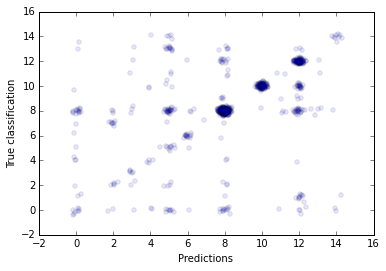

In [65]:
%%time

X_norm = log0(np.apply_along_axis(normalize1, 1, X_train))
X_norm_train, X_norm_test, y_norm_train, y_norm_test = cv.train_test_split(X_norm, y_train, test_size = 0.33, random_state=32)

y_norm_pred = getPredictions('normal', X_norm_train, y_norm_train, X_norm_test)
accuracy_score(y_norm_pred, y_norm_test)

Accuracy: 0.697742885182
CPU times: user 1min 41s, sys: 624 ms, total: 1min 42s
Wall time: 1min 42s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


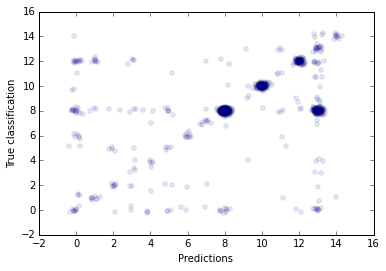

In [80]:
%%time
def mat_log(matrix, new=0) :
    logged = np.log(matrix)
    logged[logged == - float("inf")] = new
    return logged

X_norm = mat_log(np.apply_along_axis(normalize1, 1, X_train), 0)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = cv.train_test_split(X_norm, y_train, test_size = 0.33, random_state=32)

y_norm_pred = getPredictions('normal', X_norm_train, y_norm_train, X_norm_test)
accuracy_score(y_norm_pred, y_norm_test)

Accuracy: 0.8675171737


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


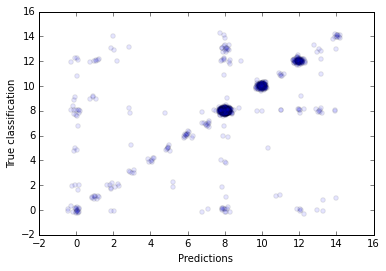

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_none_train, y_none_train)
y_none_pred = clf.predict(X_none_test)
accuracy_score(y_none_pred, y_none_test)

Accuracy: 0.864573110893


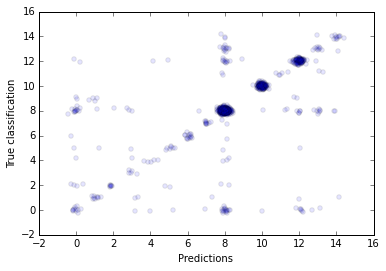

In [67]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_ind_train, y_ind_train)
y_pred = clf.predict(X_ind_test)
accuracy_score(y_pred, y_ind_test)

Accuracy: 0.868498527969


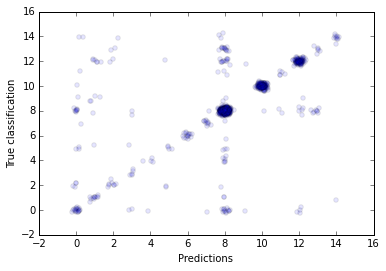

In [49]:
X_rows = X_train[:,0:64]
X_austin = X_train[:,64:X_train.shape[1]]
X_new = np.apply_along_axis(normalize1, 1, X_rows)
X_use = np.hstack((X_new, X_austin))

X_use_train, X_use_test, y_use_train, y_use_test = cv.train_test_split(X_use, y_train, test_size = 0.33, random_state=32)

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_use_train, y_use_train)
y_use_pred = clf.predict(X_use_test)
accuracy_score(y_use_pred, y_use_test)

In [44]:
%%time
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
rf_pred = clf.predict(X_test)
util.write_predictions(rf_pred, test_ids, 'pred/rf.csv')

NameError: name 'X_test' is not defined

In [84]:
%%time
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)
knn_pred = clf.predict(X_test)
util.write_predictions(knn_pred, test_ids, 'pred/knn.csv')

CPU times: user 382 ms, sys: 2.08 ms, total: 384 ms
Wall time: 383 ms


In [85]:
%%time
LR = linear_model.LogisticRegression()
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
util.write_predictions(LR_pred, test_ids, 'pred/lr.csv')

CPU times: user 2.65 s, sys: 13 ms, total: 2.66 s
Wall time: 2.67 s


In [195]:
%%time
X_norm = mat_log(np.apply_along_axis(normalize1, 1, X_train)[:,0:-1])
y_genmodel = getPredictions('normal', X_norm, y_train, X_test)
util.write_predictions(y_genmodel, test_ids, 'pred/genmodel.csv')

CPU times: user 5min 55s, sys: 2 s, total: 5min 57s
Wall time: 5min 58s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


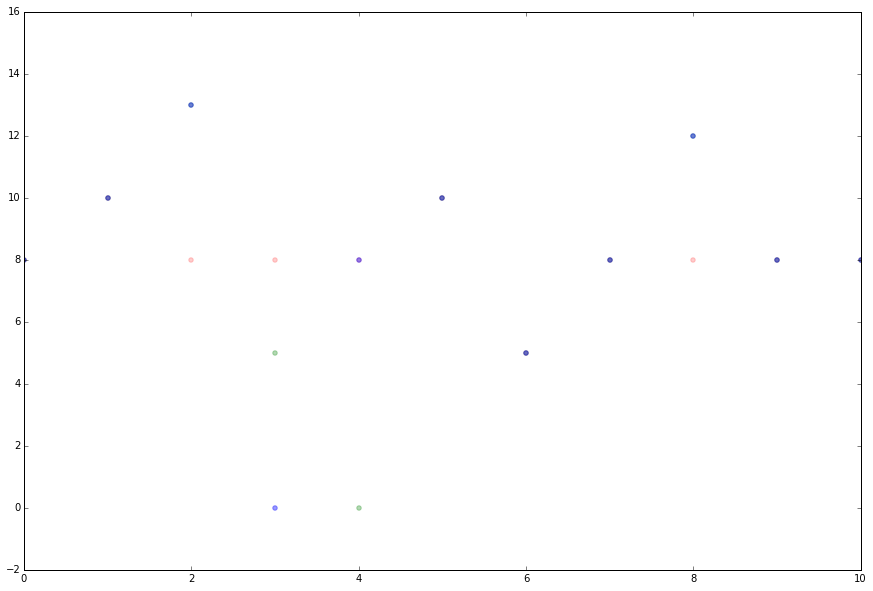

In [161]:
plt.figure(figsize=(15,10))
plt.scatter(range(3724), LR_pred, alpha=0.2, color='r');
plt.scatter(range(3724), knn_pred, alpha=0.3, color='g');
plt.scatter(range(3724), rf_pred, alpha=0.4, color='b');
plt.xlim((0,10));

In [21]:
np.vstack((LR_pred, knn_pred, rf_pred)).T[0:10,:]

NameError: name 'LR_pred' is not defined